In [26]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType
from imagededup.methods import PHash
import os

# Initialize Spark session
spark = SparkSession.builder.appName("ImageDeduplication").getOrCreate()

# Path to your image directory
image_dir = "../datasets/image"
dest_dir = "../datasets/csv"
# Read images as binary files
image_df = spark.read.format("binaryFile").load(image_dir)

# Initialize PHash object
phash = PHash()


# Define UDF to compute perceptual hash
def compute_phash(image_path):
    try:
        return phash.encode_image(image_path[5:])
    except Exception as e:
        return None


# Register UDF with Spark
phash_udf = udf(compute_phash, StringType())

# Compute phash for each image
image_df = image_df.withColumn("phash", phash_udf(col("path")))

# Convert Spark DataFrame to Pandas to use imagededup for finding duplicates
image_pd_phash = image_df.select("path", "phash")
image_pd_df = image_df.select("path", "phash").toPandas()

image_pd_phash.write.csv(dest_dir, header=True, mode="append")

In [27]:
import numpy as np

# Define max distance threshold (adjust as needed)
max_distance_threshold = 10  # Adjust this value based on similarity criteria


# Function to calculate Hamming distance between two hashes
def hamming_distance(hash1, hash2):
    return np.sum(np.array(list(format(int(hash1, 16), '064b'))) != np.array(list(format(int(hash2, 16), '064b'))))


# Find similar images
similar_images = []
for i, (path1, hash1) in enumerate(image_pd_df.itertuples(index=False)):
    for j, (path2, hash2) in enumerate(image_pd_df.itertuples(index=False)):
        if i < j and hash1 and hash2:  # Avoid duplicate comparisons
            distance = hamming_distance(hash1, hash2)
            if distance <= max_distance_threshold:
                similar_images.append((path1.split('/')[-1], path2.split('/')[-1], distance))
duplicate = {}
for img1, img2, dist in similar_images:
    tmp1 = []
    tmp2 = []

    for img1_1, img2_2, dist in similar_images:
        if img1 == img1_1:
            tmp1.append(img2_2)
        elif img1 == img2_2:
            tmp1.append(img1_1)

        if img2 == img1_1:
            tmp2.append(img2_2)
        elif img2 == img2_2:
            tmp2.append(img1_1)
    duplicate[img1] = tmp1
    duplicate[img2] = tmp2

In [28]:
spark.stop()

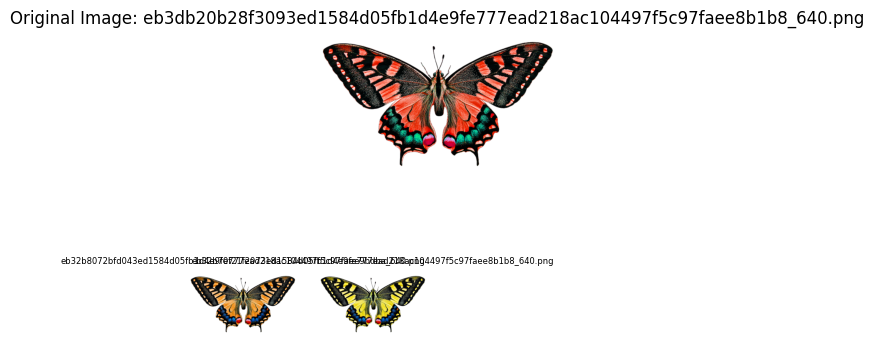

In [29]:
# plot duplicates obtained for a given file using the duplicates dictionary
from imagededup.utils import plot_duplicates

plot_duplicates(image_dir="../datasets/image",
                duplicate_map=duplicate,
                filename='eb3db20b28f3093ed1584d05fb1d4e9fe777ead218ac104497f5c97faee8b1b8_640.png')